# Spatial spectral analysis

* Purpose: Demo how to look at spatial spectral characteristics of SSH in model data from OCCIPUT, and ORCA12 with [https://github.com/adeajayi-kunle/PowerSpecAdekunle's PowerSpec package](https://github.com/adeajayi-kunle/PowerSpec).
* Goal in the 3DA context: see if results are consistent with the spectrum Yicun sent me.
* This notebooks also uses ORCA12 model data (grid resolution: 1/12º) as a check fro the spectral analysis since it provides more resolution to the spectrum than OCCIPUT.
* Note that the OCCIPUT resoltion (0.25º --> 25 km) means an effective resolution of eddies of ~ 4x 25 = 100km so spatial spectral analysis  can only provide spectral results of limited interest for the comparison of AnDA, OI and Truth.

* You can [get this notebook via gitub here](https://github.com/stephanieleroux/SHARED_NOTEBOOKS/blob/master/2019-03-28_SLX_spatialspectralanalysis_3DA.ipynb).
    

In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr
    
# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import cartopy.util as ccu
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# Adekunle's PowerSPec module: https://github.com/adeajayi-kunle/PowerSpec
import PowerSpec as ps
import Plot_PowerSpec as pp

# My custom module with plot tools for geographical maps
import utils_SLX_plots_onw as slx 

# My custom module dealing with data on the MEOM server
import SLX_tools as slxtools

# if using jupyter notebook
%matplotlib inline 

ModuleNotFoundError: No module named 'PowerSpec'

* Define spectrum plot in the same way as Adekunle

In [3]:
def plot_spec(kspec,pspec,title,diro,filo):
    """
    Plot function similar to Adekunle's, with 3 panels, but with cutoff scales more in line with our data resolution(s)
    """
    
    # - general slopes
    k = np.array([1E-6,1E-3])
    s5 = k**-5/1.e22 # k-5  QG
    s4 = k**-4/1.e17 # k-4
    s113 = k**(-11./3.)/1.e15 # k-11/3 SQG

    
    plt.suptitle(title,size = 16,y=1.05)
    
    axis1 = fig.add_subplot(131)
    plt.loglog(k,s5,'k-',label=r'$k^{-5}$')
    plt.loglog(k,s4,'k-.',label=r'$k^{-4}$')
    plt.loglog(k,s113,'k--',label=r'$k^{-11/3}$')
    plt.loglog(kspec,pspec,'g',linewidth=2)
    plt.xlim(k.min(),k.max())
    plt.ylim(1E-10,1E4)
    plt.xlabel('cpm')
    plt.ylabel('$m^2$/cpm')
    plt.title('SSH Spectra')
    plt.grid(True)
    plt.legend(loc=3)

    axis2 = fig.add_subplot(132)
    pp.plot_spectrum(kspec,pspec,40*1E3,100*1E3)
    plt.title('Slope : 40km - 100km')
    plt.ylim(1E-10,1E4)
    plt.xlim(k.min(),k.max())
    
    axis3 = fig.add_subplot(133)
    pp.plot_spectrum(kspec,pspec,70*1E3,200*1E3)
    plt.title('Slope : 70km - 200km')
    plt.ylim(1E-10,1E4)
    plt.xlim(k.min(),k.max())
    
    diro="./"
    # Save fig in png, resolution dpi
    fig.savefig(diro+filo, facecolor=fig.get_facecolor(), edgecolor='none',dpi=300,bbox_inches='tight', pad_inches=0)#

# Read data :

* Read from datasets on the MEOM server

In [4]:
SSH_occi,nav_lon_occi,nav_lat_occi = slxtools.readOCCIPUTmb1()

SSH_orca12,nav_lon_orca12,nav_lat_orca12 = slxtools.readORCA12()

* Select 2004 data only, and __center the data by removing mean__

_Note: The SSH simulated in the model is relative, so it is not necessarily  centered exactly on the same zero from one simulation to another. A quick fix to deal with this aspect is that you can remove the time-space mean of the SSH from OCCIPUT and from ORCA12 before performing your analysis._

In [5]:
SSH_occi_c   = SSH_occi.sel(time_counter='2004') - SSH_occi.sel(time_counter='2004').mean()

SSH_orca12_c = SSH_orca12.sel(time_counter='2004') - SSH_orca12.sel(time_counter='2004').mean()

# Define boundaries for the zoom region

* Define boundaries to zoom onm a 67x67 box in the loop current:

In [6]:
lonlatbounds=  np.zeros((1, 4))  # lonmin,lonmax,latmin,latmax 

# Here: entire Gulf of Mexico
lonlatbounds[0,0] = -89.05
lonlatbounds[0,1] = -83.5
lonlatbounds[0,2] = 23.
lonlatbounds[0,3] = 28.

* Initialize my general plot settings 

In [7]:
# my general plot settings for 3da
glo,xlim,ylim,coastL,coastC,coastLand,\
typlo,vmin,vmax,Nincr,su,so,\
labelplt,Nbar,pltty,dpifig,diro = slxtools.myGMexPlotsettings()

# colormap
cm_base=slx.make_NCLcolormapNOWI()

* Plot a snapshot (day 10) in the zoom box

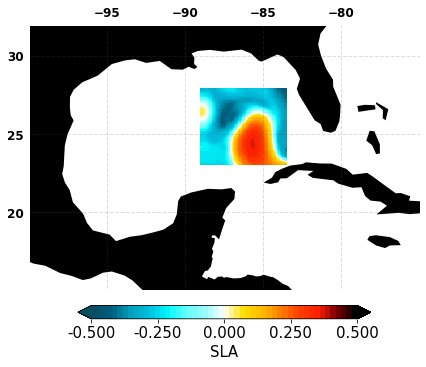

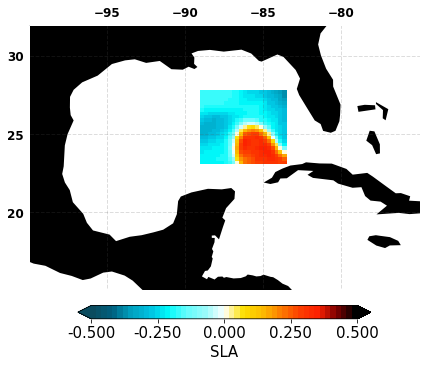

In [8]:
# day to plot
iday=10


regna="LC"
ireg=0
            
# loop on the 2 datasets:
for dataset in ('orca12','occi'): 

        if dataset=='occi':
            # apply to occiput data
            nav_lati = nav_lat_occi
            nav_loni = nav_lon_occi
            SSHi     = SSH_occi_c

        if dataset=='orca12':
            # apply to occiput data
            nav_lati = nav_lat_orca12
            nav_loni = nav_lon_orca12
            SSHi     = SSH_orca12_c

        # ============= 
        # Extract subregion
        reg, nav_lat, nav_lon  = slxtools.extractsubreg(lonlatbounds[ireg,0],lonlatbounds[ireg,1],lonlatbounds[ireg,2],lonlatbounds[ireg,3],nav_loni,nav_lati,SSHi)


        # data to plot 
        data2plot  = reg[iday,:,:].squeeze()

        # output plot file name including the time index
        plto = dataset+"_"+regna+"_SLA_MAP_DAY10_2004"

        # min/max values
        vmin=-0.5
        vmax=0.5

        #----------------------------------------------------
        #------ PLOT ----------------------------------------
        #----------------------------------------------------

        # create fig
        fig3 = plt.figure(figsize=([7,7]),facecolor='white')

        # plot data (base plot from plotmap function defined im my library)
        cs = slx.plotmap(fig3,data2plot,nav_lon.values,nav_lat.values,plto,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,coastC=coastC,incrgridlon=5,incrgridlat=5,su=su,so=so,xlim=xlim,ylim=ylim,typlo=typlo,Nbar=Nbar,labelplt=labelplt)

        # display plot
        plt.show()

        # Save fig in png, resolution dpi
        fig3.savefig(diro+"/"+plto+'.png', facecolor=fig3.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#

        # close fig
        plt.close(fig3)     

* Matrix-like plot:

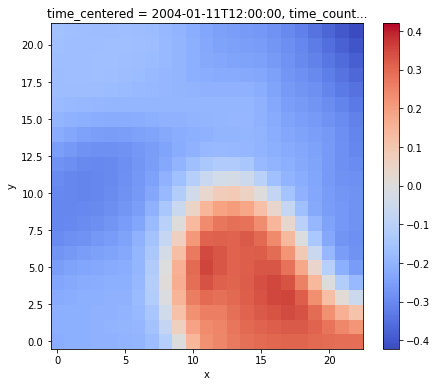

In [9]:
fig = plt.figure(figsize=(7,6))
reg[iday,:,:].plot(cmap='coolwarm')
plt.show()

# Compute spatial spectrum 

* Using  [Adekunle's PowerSPec package](https://github.com/adeajayi-kunle/PowerSpec)

* Loop on the 2 datasets occiput and orca12

/home/lerouste/.conda/envs/py36_steph_env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/lerouste/.conda/envs/py36_steph_env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


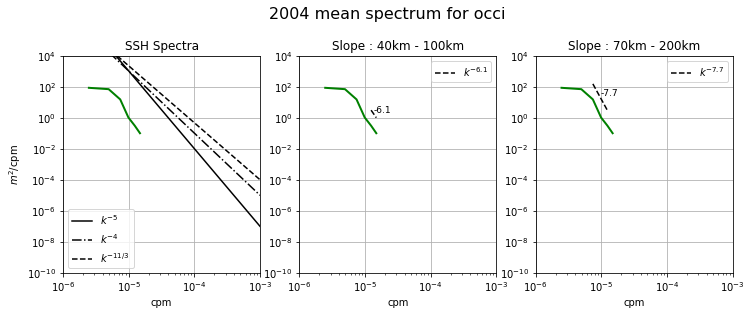

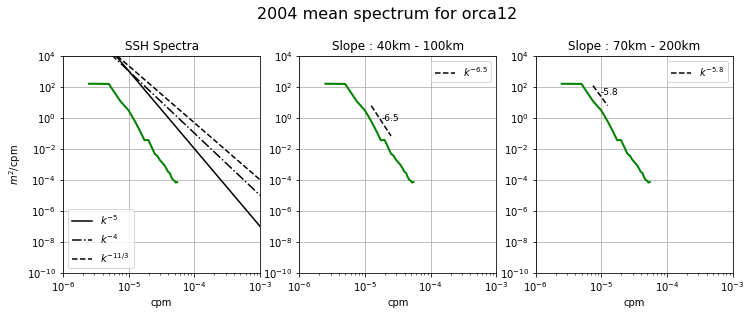

In [10]:
# code name for the subregion
regna="LC"
ireg=0
 
    
# loop on the 3 datasets:
for dataset in ('occi','orca12'): 

        lonswitch = 0.

        if dataset=='occi':
            # apply to occiput data
            nav_lati = nav_lat_occi
            nav_loni = nav_lon_occi
            SSHi     = SSH_occi_c

        if dataset=='orca12':
            # apply to occiput data
            nav_lati = nav_lat_orca12
            nav_loni = nav_lon_orca12
            SSHi     = SSH_orca12_c


        # ============= 
        # Extract subregion
        reg, nav_lat, nav_lon  = slxtools.extractsubreg(lonlatbounds[ireg,0],lonlatbounds[ireg,1],lonlatbounds[ireg,2],lonlatbounds[ireg,3],nav_loni,nav_lati,SSHi)
        
        NTIME = reg.time_counter.size

        # ============= 
        # Compute spectrum for each day , following Adekunle's method  
        
        for it in range(0,NTIME):
            
            # prepare data
            vardata = reg[it,:,:].values
            x,y,data = ps.interpolate(vardata,nav_lon,nav_lat)
            
            # - compute sepctrum and average over the year
            kspec,pspec = ps.get_spectrum(data,x,y)
            if it ==0:
                pspec2004 = (1./NTIME)*pspec 
            else:
                pspec2004 = (1./NTIME)*pspec + pspec2004
                
        # ============= 
        # PLOT spectrum 
        
        fig = plt.figure(figsize=(12,4))
        title = '2004 mean spectrum for '+dataset
        diro = './'
        # output plot file name including the time index
        plto = dataset+"_"+regna+"_SLA_SPMEAN_2004.png"
        plot_spec(kspec,pspec,title,diro,plto)   
        
        

#### Remarks and conclusions:

* Consistent spectra between the OCCCIPUT and the ORCA12 outputs. 
* Confirming the fact that the spectrum show a steep slope.  
* Julien and Adekunle say this slope is consistent with the fact the loop current is an energetic region with one main big eddy. They also say the exact value of the slope does not necessarily mean something specific in terms of turbulent regime. In this case it is more like a "transition" slope between large-scale,  very energetic eddies and the model dissipative scales.
* Note that the OCCIPUT resoltion (0.25º --> 25 km) means an effective resolution of eddies of ~ 4x 25 = 100km and so spectral analysis in space like above can only provide  limited results in terms of comparison between OI, AnDA and Truth.